In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import optuna
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, loguniform
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('train.csv')
df.head()

id  temperature  irradiance            humidity  panel_age  \
0   0     7.817315  576.179270   41.24308670850264  32.135501   
1   1    24.785727  240.003973  1.3596482765960705  19.977460   
2   2    46.652695  687.612799   91.26536837560256   1.496401   
3   3    53.339567  735.141179   96.19095521176159  18.491582   
4   4     5.575374   12.241203  27.495073003585226  30.722697   

   maintenance_count  soiling_ratio    voltage   current  module_temperature  \
0                4.0       0.803199  37.403527  1.963787           13.691147   
1                8.0       0.479456  21.843315  0.241473           27.545096   
2                4.0       0.822398  48.222882  4.191800           43.363708   
3                3.0       0.837529  46.295748  0.960567           57.720436   
4                6.0       0.551833   0.000000  0.898062            6.786263   

   cloud_coverage          wind_speed            pressure string_id  \
0       62.494044   12.82491203459621  1018.8665053152533        A1   
1       43.851238  12.012043660984917  1025.6238537572883        D4   
2             NaN   1.814399755560454  1010.9226539809573        C3   
3       67.361473   8.736258932034128  1021.8466633134253        A1   
4        3.632000    0.52268384077164  1008.5559577591927        B2   

  error_code installation_type  efficiency  
0        NaN               NaN    0.562096  
1        E00         dual-axis    0.396447  
2        E00               NaN    0.573776  
3        NaN         dual-axis    0.629009  
4        E00             fixed    0.341874

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non-null  object 
 16  effi

In [4]:
df.describe()

id   temperature    irradiance     panel_age  \
count  20000.000000  18999.000000  19013.000000  18989.000000   
mean    9999.500000     25.077241    501.273896     17.509758   
std     5773.647028     12.513129    250.926590     10.097557   
min        0.000000      0.000000   -597.278646      0.001264   
25%     4999.750000     16.853522    332.227277      8.777905   
50%     9999.500000     24.720345    499.654730     17.497731   
75%    14999.250000     32.848917    668.416734     26.340761   
max    19999.000000    147.394168   1537.810349     34.998379   

       maintenance_count  soiling_ratio       voltage       current  \
count       18973.000000   18990.000000  19007.000000  19023.000000   
mean            4.012070       0.698879     16.242251      1.713396   
std             2.002268       0.172244     17.889031      1.152953   
min             0.000000       0.400149      0.000000      0.000054   
25%             3.000000       0.550654      0.000000      0.772311   
50%             4.000000       0.697663     12.350138      1.558413   
75%             5.000000       0.847838     26.557322      2.474744   
max            15.000000       0.999949    494.279016      7.315597   

       module_temperature  cloud_coverage    efficiency  
count        19022.000000    18990.000000  20000.000000  
mean            29.923807       51.378575      0.510260  
std             12.125405       48.473664      0.140420  
min              0.000000        0.000244      0.000000  
25%             21.522124       25.081618      0.445613  
50%             29.857669       49.704133      0.515709  
75%             38.094943       75.052824      0.590324  
max             65.000000     1000.000000      0.987066

In [5]:
df.dropna(how='all',inplace=True)
df.shape

(20000, 17)

In [6]:
df.duplicated().value_counts()

False    20000
dtype: int64

## Inspect Temperature col

In [7]:
# Values above 70 are not natural
df["temperature"] = df["temperature"].clip(-20, 70)


## Irradiance

In [8]:
df[df.irradiance<1000].loc[:100,['cloud_coverage','temperature','irradiance']]

cloud_coverage  temperature  irradiance
0         62.494044     7.817315  576.179270
1         43.851238    24.785727  240.003973
2               NaN    46.652695  687.612799
3         67.361473    53.339567  735.141179
4          3.632000     5.575374   12.241203
5         11.170874    16.545541  174.455123
6         31.736361    18.728064  531.960101
7         59.135879    52.060643  420.939352
8         80.595045    24.180080  495.799711
9         34.358446    37.895969  286.739018
10        25.728687    28.596486  719.849494
11        75.999072          NaN  694.447984
13        88.721946    17.642899  781.810302
14        54.483190    52.802479  616.877336
15        32.113179    28.091359  285.176884
16        79.808007    37.652488  592.187696
17        19.065492     7.981089  260.279350
18        86.287737    21.097337  719.612575
19        20.086442    34.346127  487.518522
20        52.809943    11.905996  453.784409
21        57.627553    24.232391  329.767614
22        71.273068    14.442807  805.635335
23        87.128233    34.917213  461.367629
24         6.278273    29.782199  392.918044
25        43.302917    33.200625  411.966612
26        74.074874    35.452900  633.077296
27        75.307073    22.267902  591.361016
28        93.401635    37.038781  603.183153
29         4.587801    17.921822  607.705251
32        26.454482    16.043726  371.939318
33        74.449261    52.789638  296.556818
34        23.056861    32.331855  653.994856
35        21.887933    32.336163  782.243073
36        93.734107    15.113249  471.513136
37        73.988196    11.869475  289.960881
38        66.072047    21.827678  293.879696
39        54.079398    24.194458  662.648197
41        40.604301    37.227273  635.788567
42        89.284946    26.307134  333.622573
43        34.930483    25.788554  558.040331
44        50.613056    34.097689  529.171452
45        80.130261     9.174450  554.672149
46        32.726848     1.943801  717.857194
47        85.359181    33.920657  555.898887
48        58.855018    25.864152  669.728391
49        85.223474          NaN  516.894767
50        26.430069     0.000000  572.279850
51        62.535036    35.726402  657.822056
52        45.327653    18.741338  135.711045
53        12.113385    29.803128  420.082196
54        17.752962    21.834880  382.406836
55        49.779042    24.589132  340.280538
56        79.268759    17.892991  431.214437
57        65.716779    24.081880  873.735328
58        45.249756    31.924879  283.542221
59        82.787508    21.691258  742.069589
60        42.914973    21.006117   79.282557
61         5.468889    32.290455  416.278743
62        99.274285    33.090159  540.688266
63        68.071809    11.350117  646.555583
64        38.343104    24.653094  677.806645
65        88.669619    18.714846  698.336809
66        80.651527    25.164616  412.818732
67        90.653510    42.207603  384.412052
69         6.558027    50.970939  452.173919
70         9.822019    27.635134  181.078419
71        26.496804    23.002498  216.678196
72        53.587312    24.763810  270.136928
73        92.295293    26.711558  624.290186
74        88.806139    28.874217  535.606434
75        49.082845    13.096392  672.621339
76        90.047621    22.202078  393.186838
77        19.341892    16.307247  539.634923
78        55.669123    37.355465  656.397598
79        14.493848     1.891977  422.663365
80        42.009337    26.882836  614.193809
81        35.539942     6.781963  334.518515
82        38.574175    30.186856  409.236538
83        57.392381    20.213141  404.565527
84        63.908035     3.198465  201.040089
85        44.916623    36.306767  621.743120
86        79.264443     0.000000  382.649415
87        94.186719    24.622966  503.123530
88        14.440227    33.294286  620.186665
89        40.898586    41.520781  611.632794
90        20.685011     5.678118  666.346277
91        82.551734    18.807714  475.378629
92              NaN    38.003836  394.175422


In [9]:
# Values below 0 is not possible, values above 1300 are also likely errors
df["irradiance"] = df["irradiance"].clip(0, 1300)

#df.loc[df['irradiance'] < 0, 'irradiance'] = np.nan


## Voltage

In [10]:
# max is 48-50 V for residential use. Looking at the values, as most lie (75% percentile) below 26 we can say that the values in dataset are of residential panels.
df["voltage"] = df["voltage"].clip(0, 43)


## Could coverage

In [11]:
# value is in %, it is likely that 1000 was miss typed as 100, as the only value above 100 is 1000
df[df.cloud_coverage>100]
df.loc[df['cloud_coverage'] > 100, 'cloud_coverage'] = 100


## Humidity

In [12]:
df.humidity.value_counts()

unknown                 50
error                   40
badval                  37
49.75405575152114        1
4.749053121788882        1
46.46312317231862        1
62.33812073981084        1
80.79252510053763        1
38.75163815614498        1
90.0985298932522         1
37.427486007938896       1
61.74873659116946        1
2.7062326070568687       1
8.079924983067166        1
36.127126092084524       1
10.761254155174694       1
30.81677455267092        1
84.83182323468982        1
6.767678687854661        1
85.219060920715          1
21.711075185152172       1
53.18356208231029        1
27.713317703521902       1
18.94084075304544        1
48.00032111162975        1
3.958834492568164        1
23.688382692250578       1
56.787641928064815       1
70.94219981747945        1
55.11431057887679        1
54.031828530521054       1
53.94365101918106        1
43.73416440406945        1
7.34072591437841         1
20.802505087356504       1
72.63633945873605        1
81.75385176029666        1
7

In [13]:
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['humidity'] = df['humidity'].astype(float)


## Wind speed

In [14]:
df.wind_speed.value_counts()

badval                   42
error                    41
unknown                  36
12.82491203459621         1
4.653074989366715         1
8.356641417510872         1
2.5364854384637603        1
10.432486138382325        1
14.594092251017132        1
0.6990321262612109        1
10.503656073741583        1
9.561946660787026         1
6.994479086414041         1
6.732138719822226         1
6.417537758394348         1
7.719295543229015         1
8.385400424858926         1
10.021739253669125        1
14.872238484382445        1
2.124264019503536         1
13.632267283837123        1
12.15587770525882         1
11.85257230850229         1
11.3718984818409          1
4.415057815856454         1
12.321684359986778        1
9.722608927866903         1
8.701699782909962         1
2.177450452404162         1
14.056117640960416        1
5.967204177723074         1
1.100246003364681         1
8.446391770577302         1
8.777990210130616         1
11.575108166552175        1
0.7888478072060456  

In [15]:
df['wind_speed'] = pd.to_numeric(df['wind_speed'], errors='coerce')
df['wind_speed'] = df['wind_speed'].astype(float)


## Pressure

In [16]:
df.pressure.value_counts()

unknown               46
error                 45
badval                44
1008.5019530390653     1
1015.6842178751405     1
1011.2930808349005     1
1021.0280143513153     1
1025.3804155587165     1
1015.750540908437      1
989.0642879704246      1
1012.9573693853295     1
1004.5550986589192     1
1014.9914147346966     1
1016.8756957341968     1
986.920139150046       1
989.5465266326279      1
1022.6336848799914     1
1015.4526514099205     1
1009.1946020115902     1
1028.5435068479235     1
1018.8665053152533     1
999.042683202841       1
1029.682648945671      1
1023.0144246786705     1
1006.0828706421057     1
1020.4259953570972     1
1009.2066308643325     1
1026.6495575298557     1
1016.5011946058496     1
1006.9082108037252     1
997.9668110803512      1
1002.2371186175869     1
1025.4716539323683     1
995.9538133503472      1
1003.4693697423049     1
1033.491999175017      1
1001.4326330740573     1
1016.7151411215834     1
1014.1554640087805     1
1012.9897575511103     1


In [17]:
df['pressure'] = pd.to_numeric(df['pressure'], errors='coerce')
df['pressure'] = df['pressure'].astype(float)


## String ids

In [18]:
df.string_id.value_counts()

D4    5080
B2    5014
C3    5004
A1    4902
Name: string_id, dtype: int64

In [19]:
df['string_id'] = df['string_id'].fillna('unknown')
df = pd.get_dummies(df, columns=['string_id'], prefix='str')


In [20]:
df.head()

id  temperature  irradiance   humidity  panel_age  maintenance_count  \
0   0     7.817315  576.179270  41.243087  32.135501                4.0   
1   1    24.785727  240.003973   1.359648  19.977460                8.0   
2   2    46.652695  687.612799  91.265368   1.496401                4.0   
3   3    53.339567  735.141179  96.190955  18.491582                3.0   
4   4     5.575374   12.241203  27.495073  30.722697                6.0   

   soiling_ratio    voltage   current  module_temperature  cloud_coverage  \
0       0.803199  37.403527  1.963787           13.691147       62.494044   
1       0.479456  21.843315  0.241473           27.545096       43.851238   
2       0.822398  43.000000  4.191800           43.363708             NaN   
3       0.837529  43.000000  0.960567           57.720436       67.361473   
4       0.551833   0.000000  0.898062            6.786263        3.632000   

   wind_speed     pressure error_code installation_type  efficiency  str_A1  \
0   12.824912  1018.866505        NaN               NaN    0.562096       1   
1   12.012044  1025.623854        E00         dual-axis    0.396447       0   
2    1.814400  1010.922654        E00               NaN    0.573776       0   
3    8.736259  1021.846663        NaN         dual-axis    0.629009       1   
4    0.522684  1008.555958        E00             fixed    0.341874       0   

   str_B2  str_C3  str_D4  
0       0       0       0  
1       0       0       1  
2       0       1       0  
3       0       0       0  
4       1       0       0

## Error code

In [21]:
df.error_code.value_counts()

E00    5977
E01    4100
E02    4011
Name: error_code, dtype: int64

In [22]:
df['error_code'] = df['error_code'].fillna('unknown')
df = pd.get_dummies(df, columns=['error_code'], prefix='error')


In [23]:
# we have thus converted all the values to numeric

In [24]:
# we  will not be needing the id
df.drop(['id'],axis=1,inplace=True)

## Installation type

In [25]:
df.installation_type.value_counts()

tracking     5067
fixed        4990
dual-axis    4915
Name: installation_type, dtype: int64

In [26]:
df['installation_type'] = df['installation_type'].fillna('unknown')

df = pd.get_dummies(df, columns=['installation_type'], prefix='install') #df['installation_type'].map({'unknown':-1,'fixed':0,'tracking':2,'dual-axis':3}) #

df.head()

temperature  irradiance   humidity  panel_age  maintenance_count  \
0     7.817315  576.179270  41.243087  32.135501                4.0   
1    24.785727  240.003973   1.359648  19.977460                8.0   
2    46.652695  687.612799  91.265368   1.496401                4.0   
3    53.339567  735.141179  96.190955  18.491582                3.0   
4     5.575374   12.241203  27.495073  30.722697                6.0   

   soiling_ratio    voltage   current  module_temperature  cloud_coverage  \
0       0.803199  37.403527  1.963787           13.691147       62.494044   
1       0.479456  21.843315  0.241473           27.545096       43.851238   
2       0.822398  43.000000  4.191800           43.363708             NaN   
3       0.837529  43.000000  0.960567           57.720436       67.361473   
4       0.551833   0.000000  0.898062            6.786263        3.632000   

   wind_speed     pressure  efficiency  str_A1  str_B2  str_C3  str_D4  \
0   12.824912  1018.866505    0.562096       1       0       0       0   
1   12.012044  1025.623854    0.396447       0       0       0       1   
2    1.814400  1010.922654    0.573776       0       0       1       0   
3    8.736259  1021.846663    0.629009       1       0       0       0   
4    0.522684  1008.555958    0.341874       0       1       0       0   

   error_E00  error_E01  error_E02  error_unknown  install_dual-axis  \
0          0          0          0              1                  0   
1          1          0          0              0                  1   
2          1          0          0              0                  0   
3          0          0          0              1                  1   
4          1          0          0              0                  0   

   install_fixed  install_tracking  install_unknown  
0              0                 0                1  
1              0                 0                0  
2              0                 0                1  
3              0                 0                0  
4              1                 0                0

## Maintenance

In [27]:
df.maintenance_count.value_counts()

3.0     3744
4.0     3703
5.0     2988
2.0     2785
6.0     1948
1.0     1331
7.0     1108
8.0      593
0.0      349
9.0      271
10.0      98
11.0      37
12.0      14
13.0       3
15.0       1
Name: maintenance_count, dtype: int64

# EDA

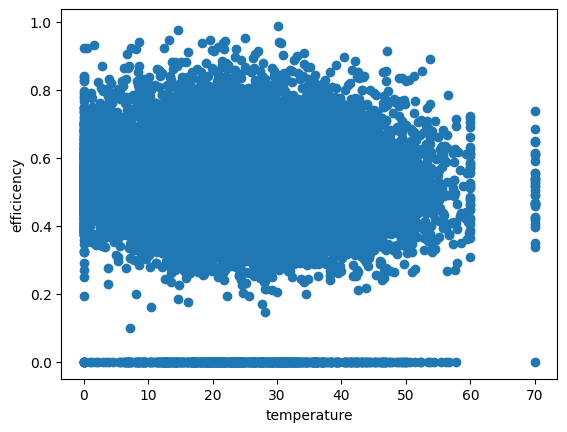

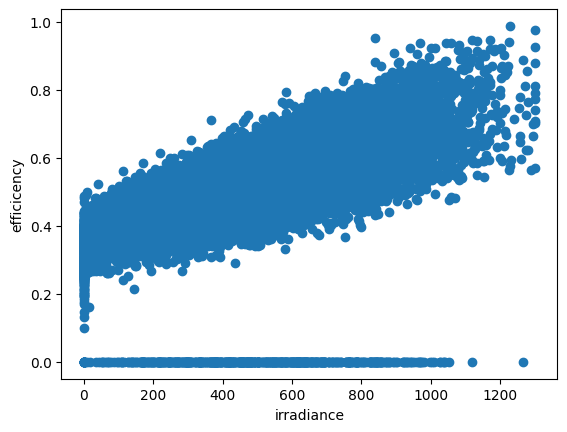

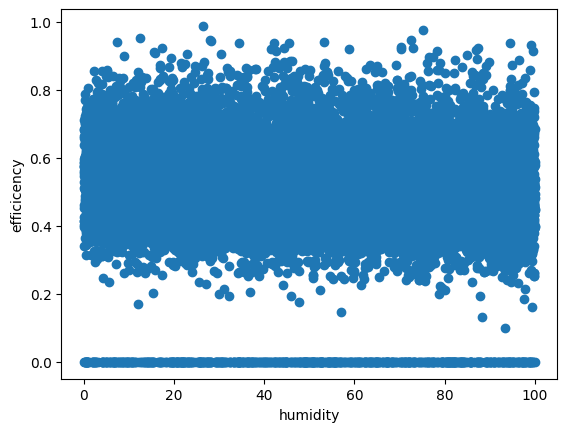

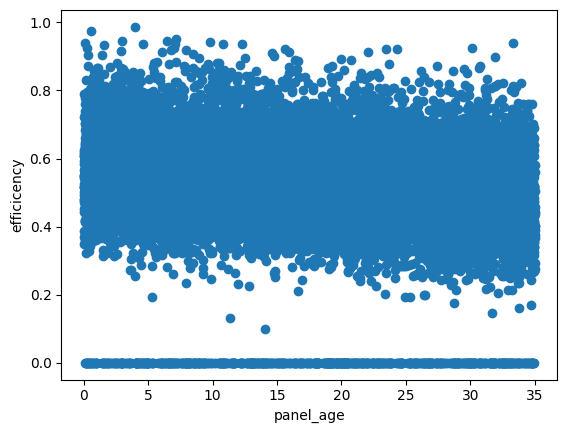

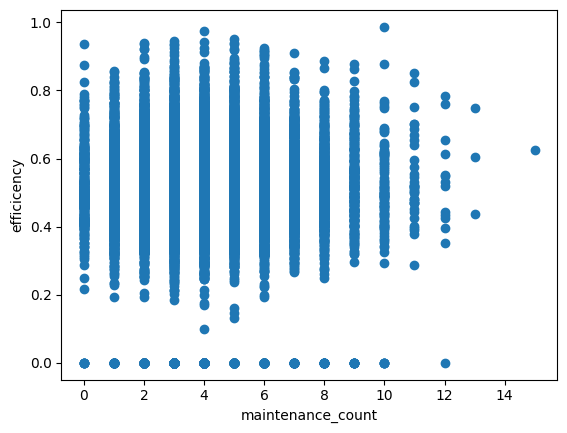

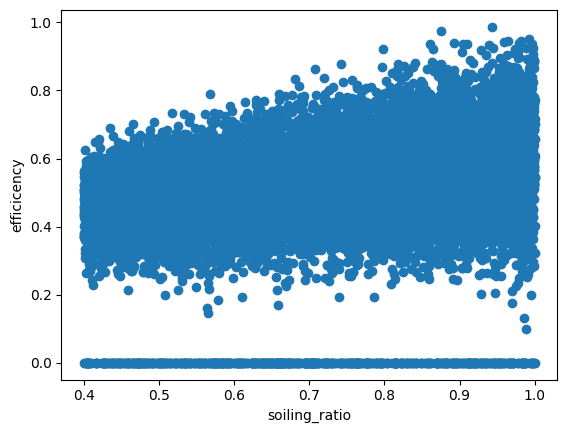

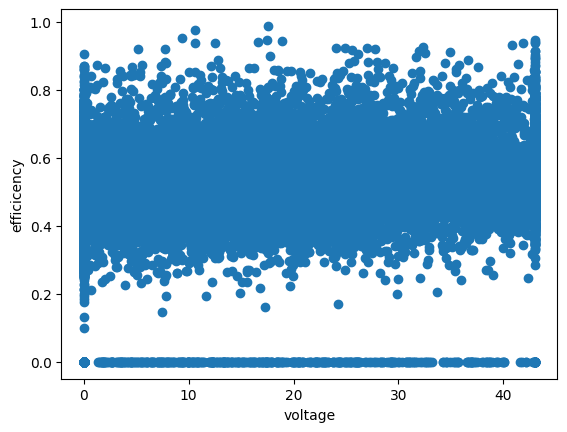

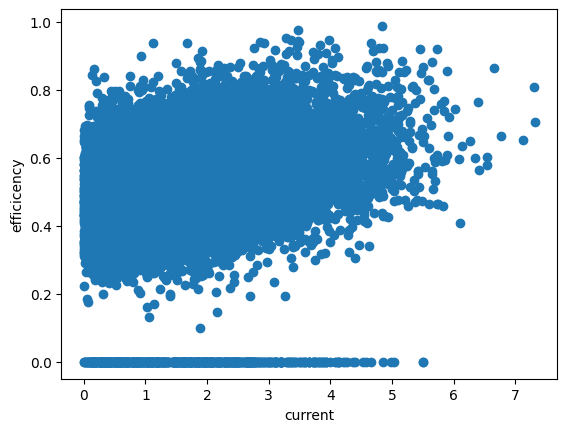

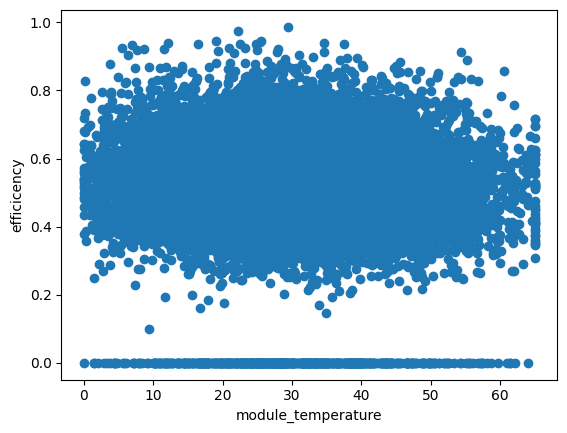

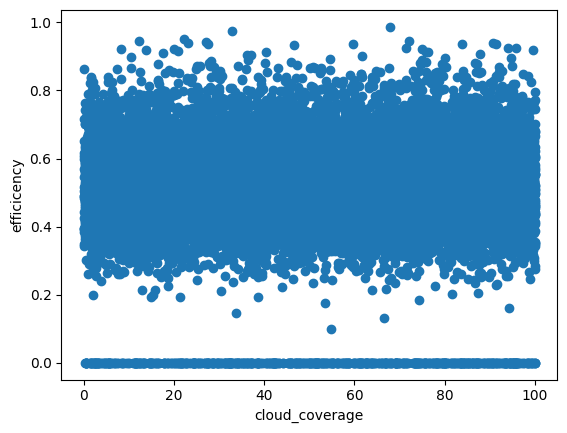

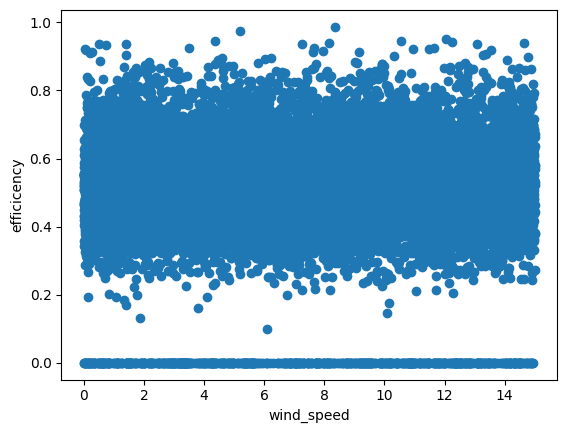

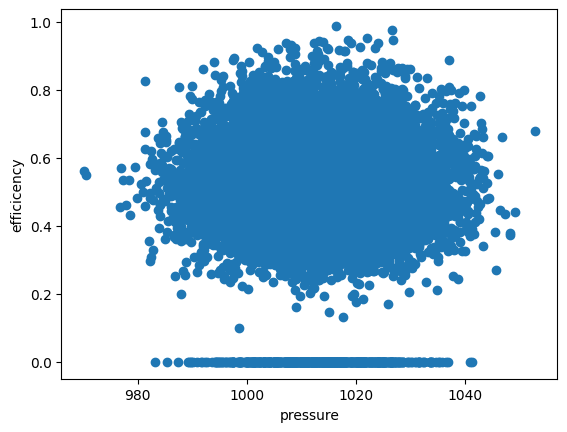

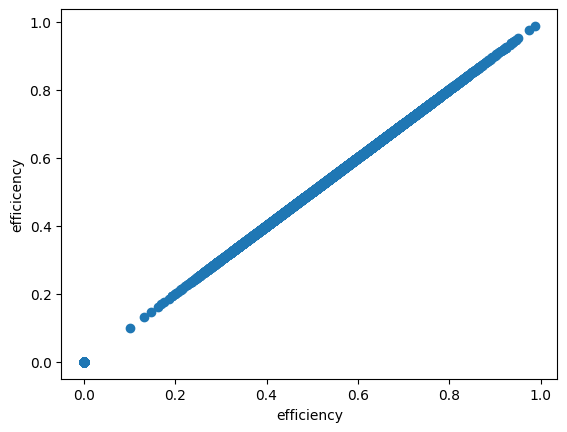

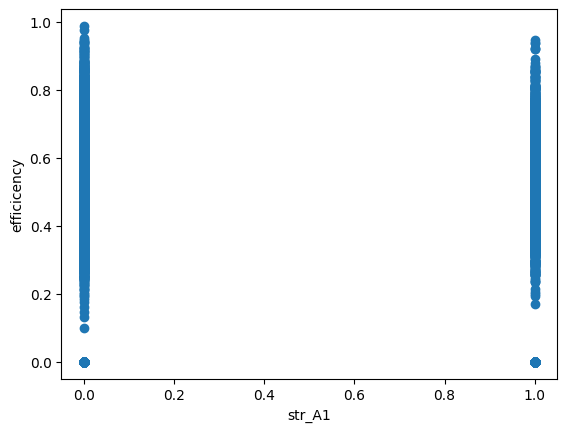

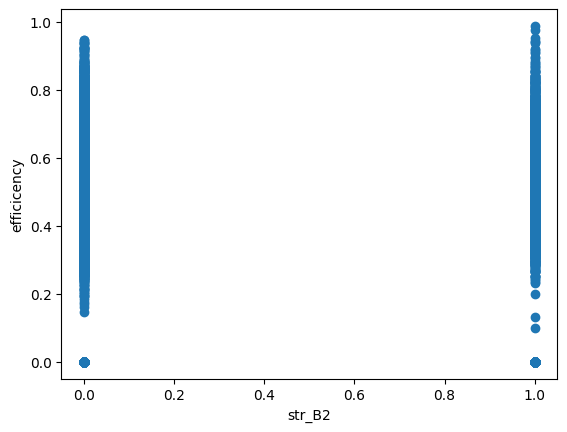

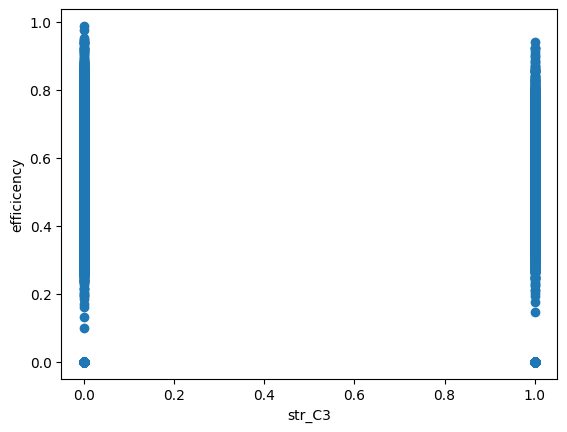

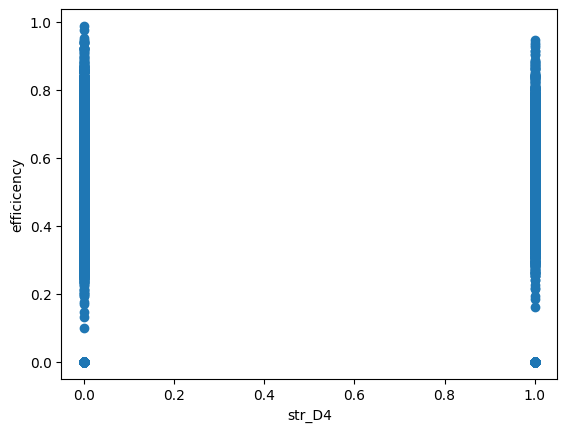

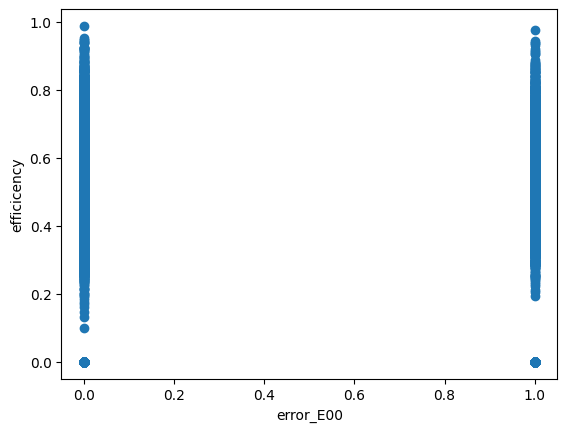

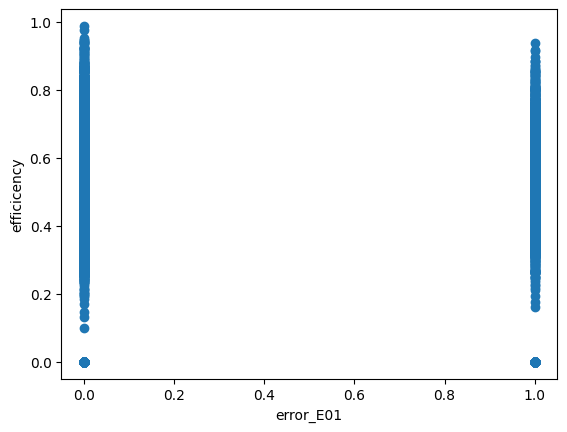

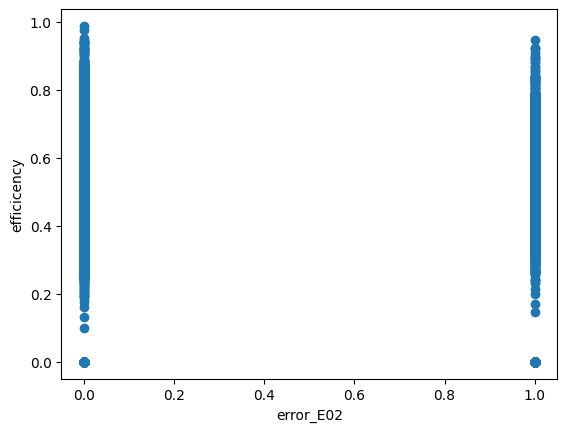

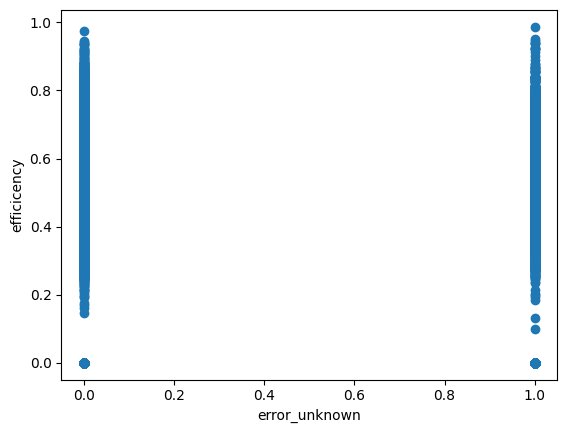

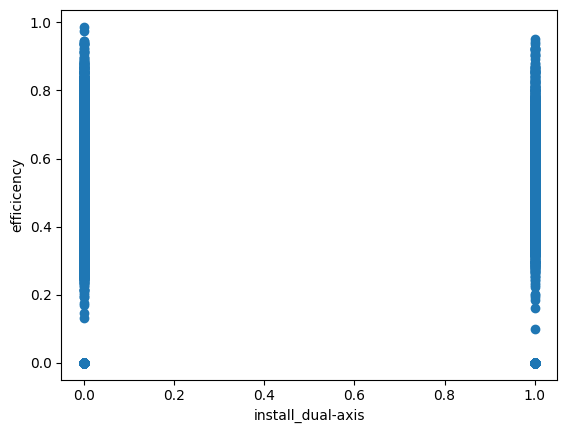

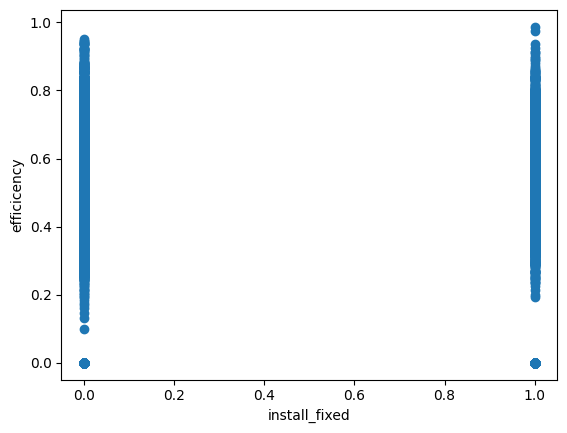

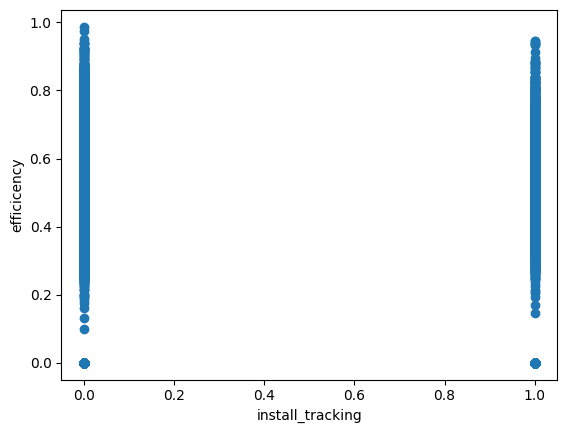

In [28]:
for col in df.columns[:-1]:
    plt.scatter(df[col],df['efficiency'])
    plt.xlabel(col)
    plt.ylabel('efficicency')
    plt.show()

In [29]:
# None of the feat show a strong corr with the target. Perphaps there is no linear reln.
df.corr()['efficiency']

temperature          -0.045607
irradiance            0.578369
humidity             -0.065666
panel_age            -0.187855
maintenance_count     0.016274
soiling_ratio         0.293931
voltage               0.168637
current               0.270045
module_temperature   -0.049686
cloud_coverage       -0.010941
wind_speed           -0.004643
pressure             -0.004975
efficiency            1.000000
str_A1               -0.014854
str_B2                0.004152
str_C3                0.010492
str_D4                0.000104
error_E00             0.000202
error_E01            -0.011656
error_E02            -0.001521
error_unknown         0.011445
install_dual-axis    -0.013517
install_fixed         0.002661
install_tracking      0.005678
install_unknown       0.005067
Name: efficiency, dtype: float64

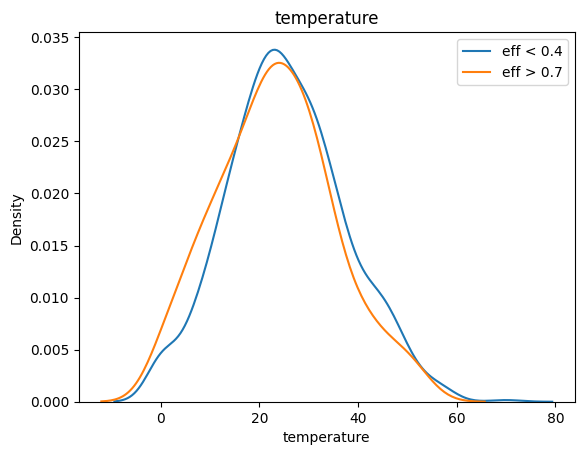

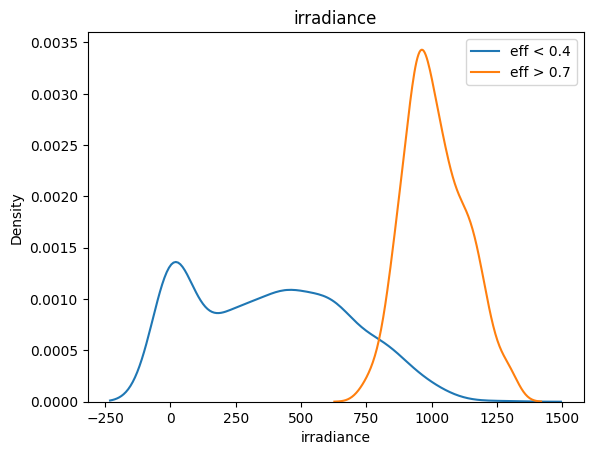

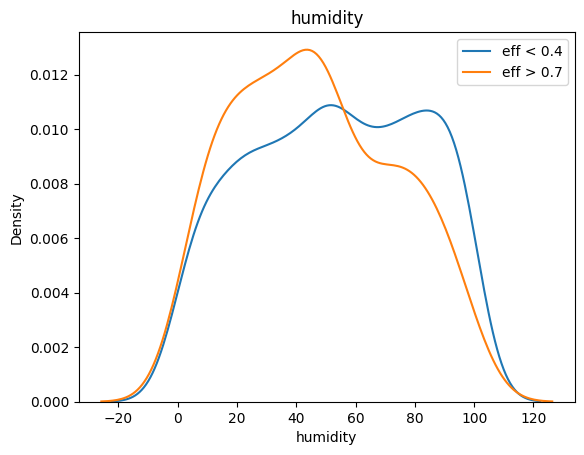

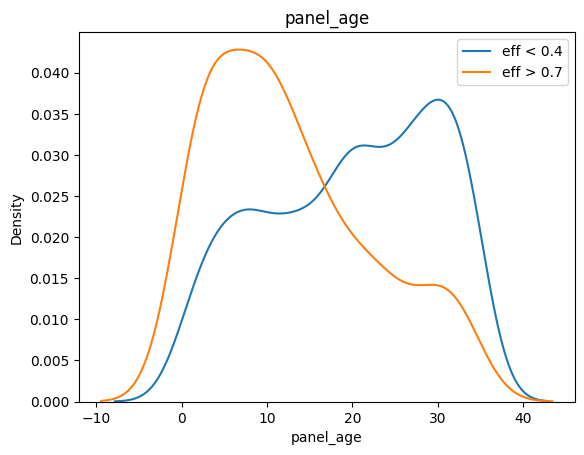

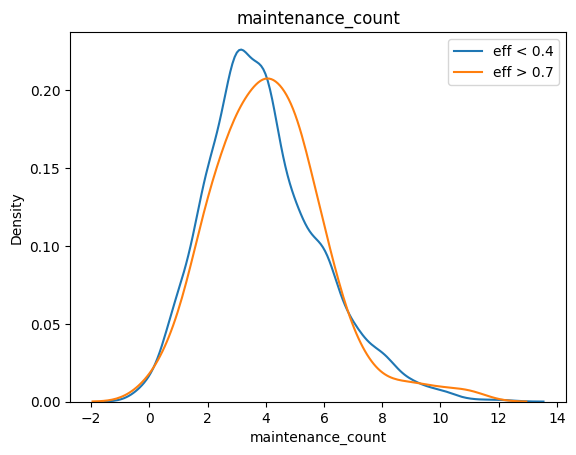

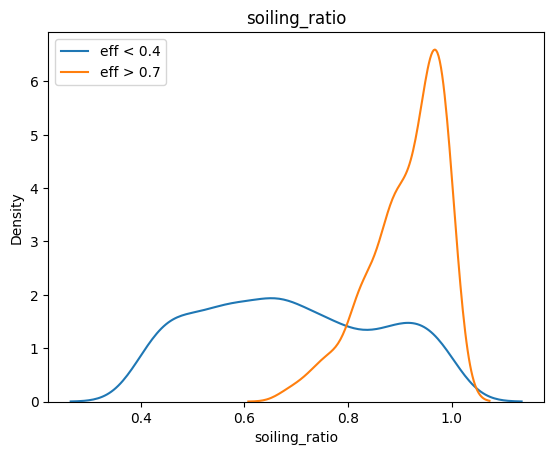

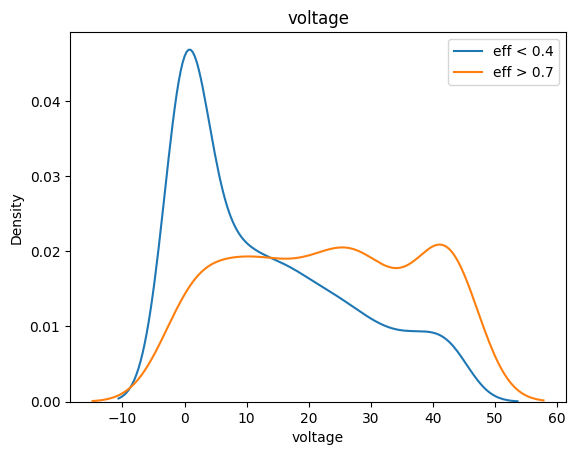

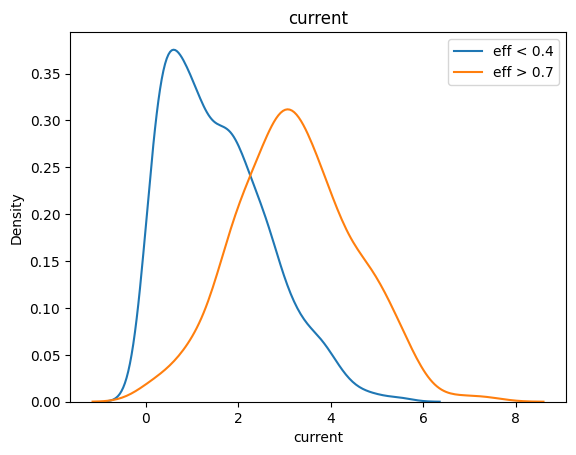

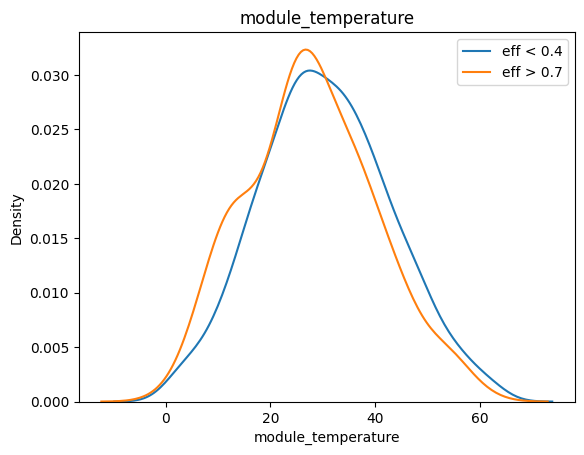

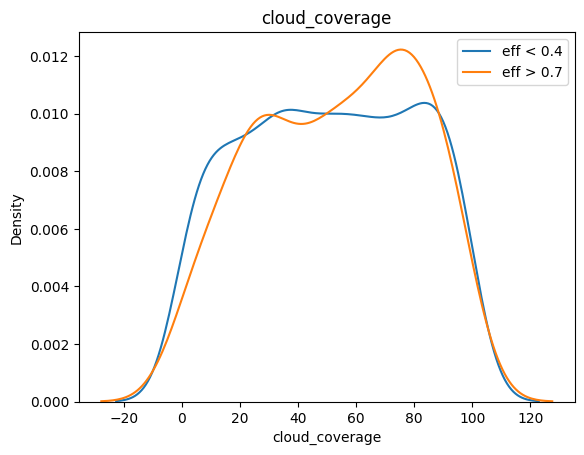

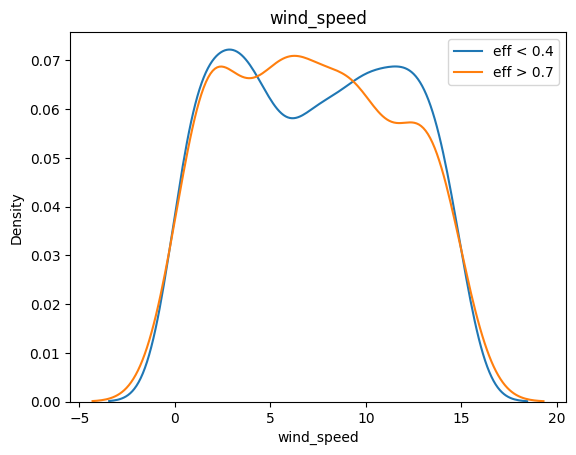

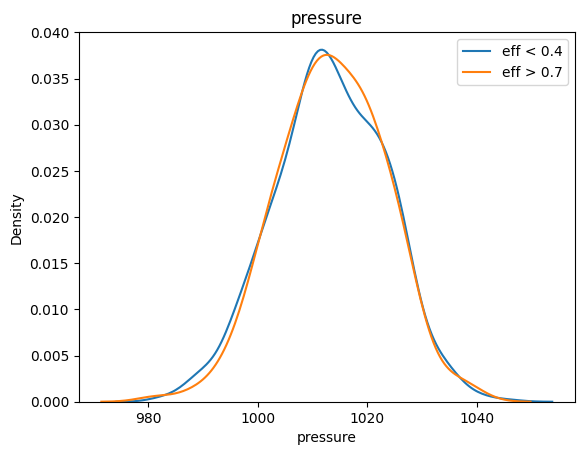

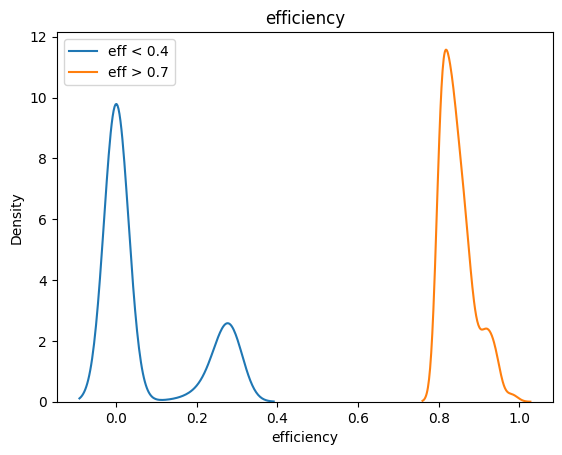

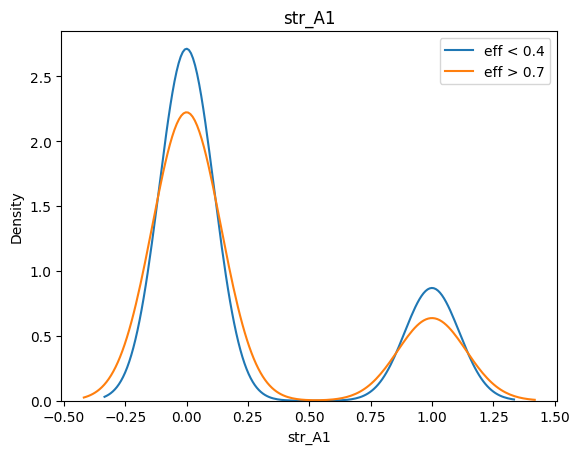

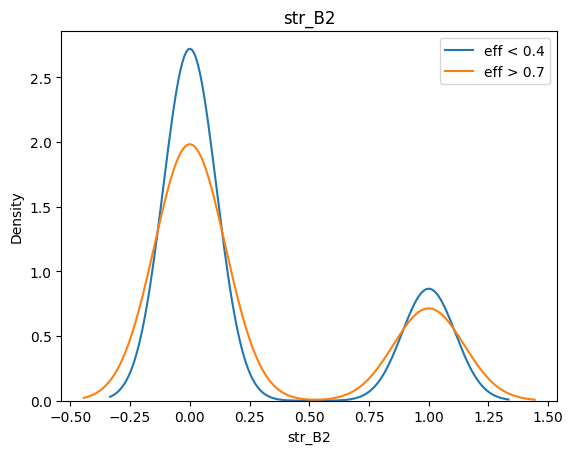

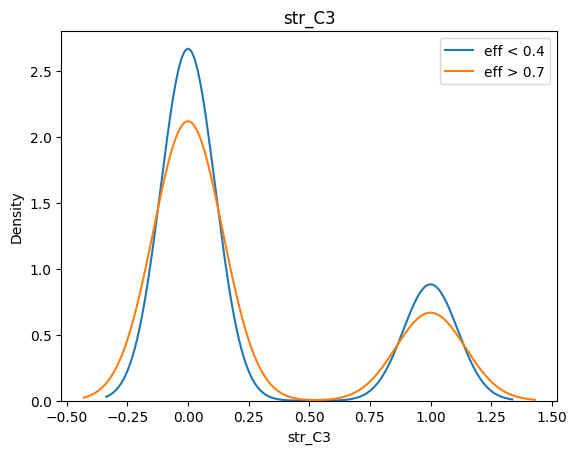

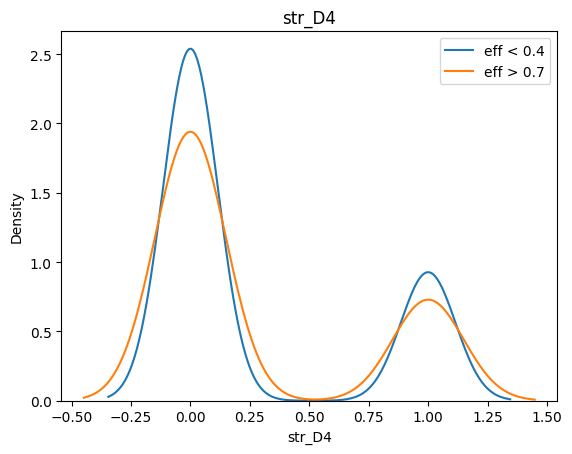

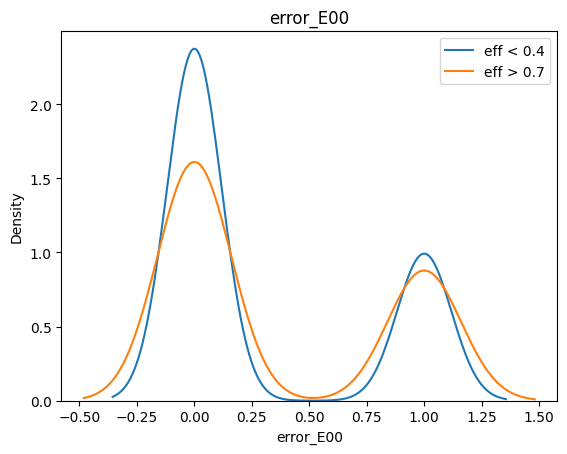

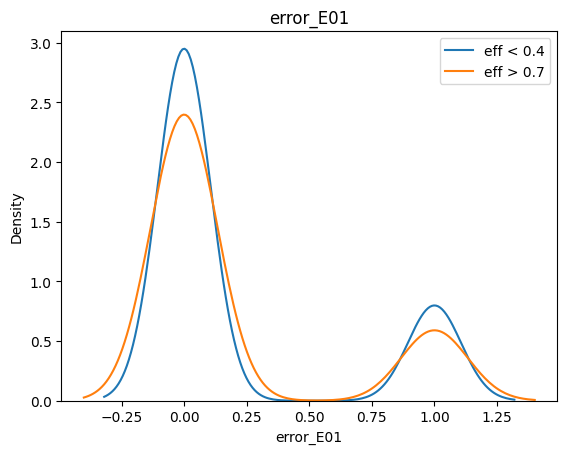

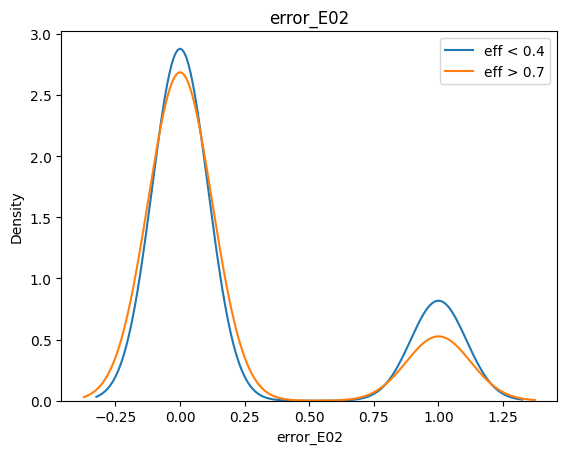

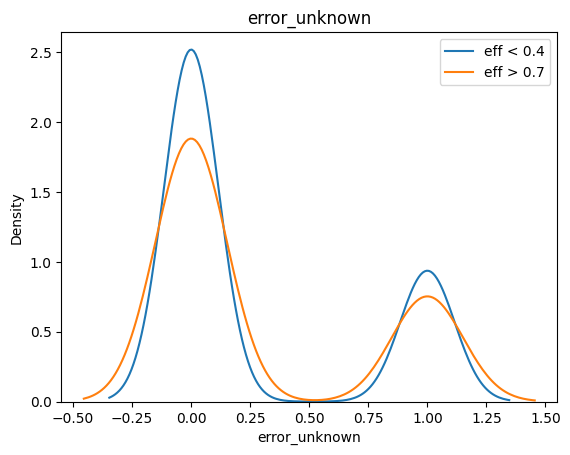

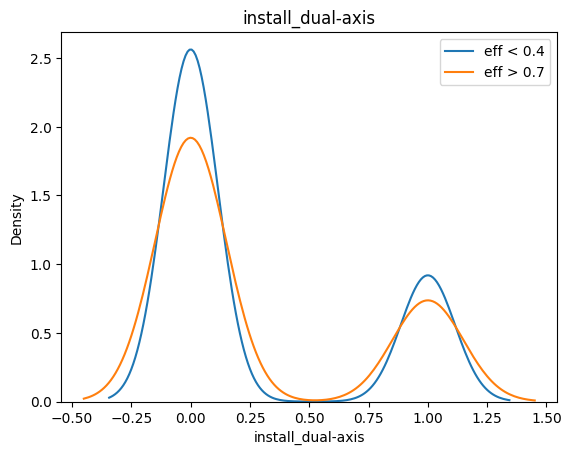

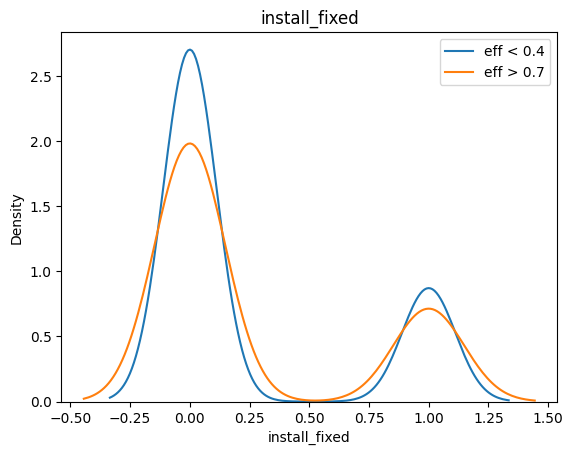

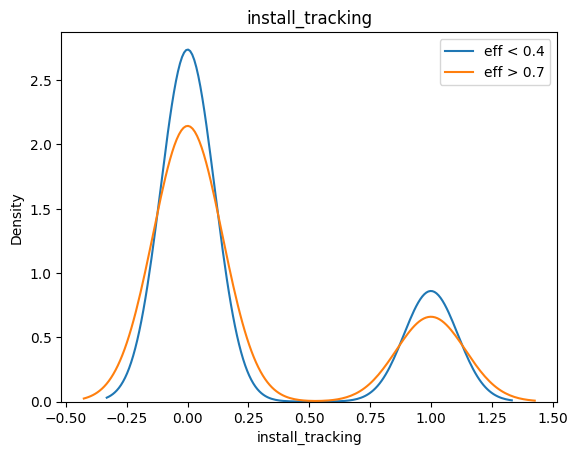

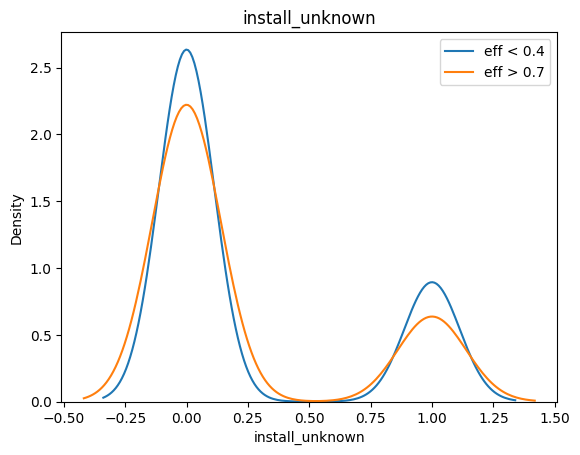

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in df.columns:
    plt.figure()
    sns.kdeplot(df[df.efficiency < 0.3][col], label='eff < 0.4')
    sns.kdeplot(df[df.efficiency > 0.8][col], label='eff > 0.7')
    plt.title(col)
    plt.legend()
    plt.show()


<AxesSubplot: >

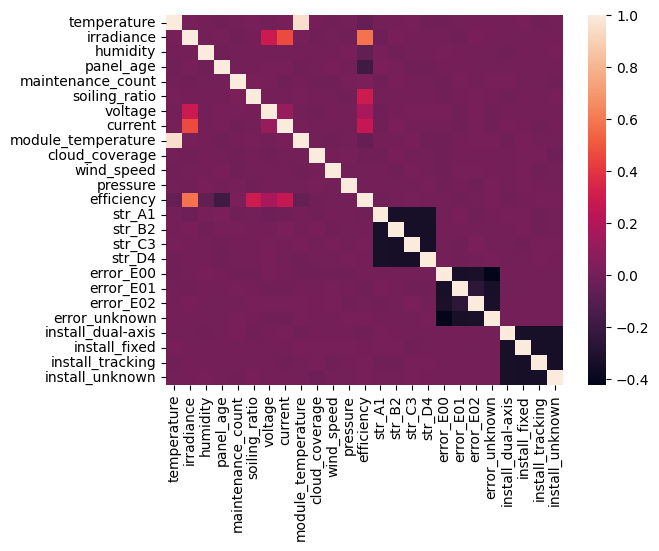

In [31]:
# ambiant temp and module temp are related as expected. Other than that, no conclusion can be drawn
sns.heatmap(df.corr())

## Handling missing values

In [32]:
df.isnull().any(axis=1).sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0        False
1        False
2         True
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11        True
12        True
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27        True
28       False
29       False
30       False
31        True
32       False
33       False
34       False
35       False
36       False
37        True
38       False
39       False
40        True
41       False
42       False
43        True
44       False
45       False
46       False
47        True
48       False
49        True
50       False
51       False
52        True
53       False
54       False
55       False
56       False
57       False
58        True
59       False
60        True
61       False
62      

In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cat_cols = ['error_code', 'string_id','installation_type']
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(cat_cols+['efficiency'])

# For numeric columns
imputer = IterativeImputer(random_state=42)
df[num_cols] = imputer.fit_transform(df[num_cols])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         20000 non-null  float64
 1   irradiance          20000 non-null  float64
 2   humidity            20000 non-null  float64
 3   panel_age           20000 non-null  float64
 4   maintenance_count   20000 non-null  float64
 5   soiling_ratio       20000 non-null  float64
 6   voltage             20000 non-null  float64
 7   current             20000 non-null  float64
 8   module_temperature  20000 non-null  float64
 9   cloud_coverage      20000 non-null  float64
 10  wind_speed          20000 non-null  float64
 11  pressure            20000 non-null  float64
 12  efficiency          20000 non-null  float64
 13  str_A1              20000 non-null  uint8  
 14  str_B2              20000 non-null  uint8  
 15  str_C3              20000 non-null  uint8  
 16  str_

## Train test split

In [35]:
df.columns

Index(['temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'voltage', 'current',
       'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure',
       'efficiency', 'str_A1', 'str_B2', 'str_C3', 'str_D4', 'error_E00',
       'error_E01', 'error_E02', 'error_unknown', 'install_dual-axis',
       'install_fixed', 'install_tracking', 'install_unknown'],
      dtype='object')

### Model and Eval

In [36]:

df_clean = df[~(df["efficiency"] <0.14)]

df_clean.corr()['efficiency']

temperature          -0.062248
irradiance            0.761374
humidity             -0.085241
panel_age            -0.239504
maintenance_count     0.016257
soiling_ratio         0.381334
voltage               0.222802
current               0.369946
module_temperature   -0.064255
cloud_coverage       -0.004017
wind_speed           -0.009310
pressure             -0.004403
efficiency            1.000000
str_A1               -0.024723
str_B2                0.006164
str_C3                0.008722
str_D4                0.009634
error_E00            -0.001959
error_E01            -0.013626
error_E02             0.008153
error_unknown         0.006869
install_dual-axis    -0.006266
install_fixed        -0.000401
install_tracking     -0.002378
install_unknown       0.008998
Name: efficiency, dtype: float64

In [37]:
from sklearn.preprocessing import RobustScaler

X= df_clean[['temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'module_temperature', 'voltage','current']]
y=df_clean['efficiency']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=40) #40

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Hyperparameter tuning

In [38]:
##Hyperparameter tuning for catboost

# The objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-5, 0.1, log=True),
        'verbose': 0
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_scaled, y_train)

    preds = model.predict(X_test_scaled)
    score = 100 * (1 - np.sqrt(mean_squared_error(y_test, preds)))
    return -score  # Minimize the negative score (so maximizing actual score)

# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best result
print("Best trial:")
trial = study.best_trial
print(f"Score: {-trial.value}")
print("Best hyperparameters:", trial.params)


[I 2025-06-09 18:48:15,148] A new study created in memory with name: no-name-afd850ec-dcd3-4863-8ff8-9384d8bc2351
[I 2025-06-09 18:48:19,767] Trial 0 finished with value: -95.69299097250669 and parameters: {'iterations': 1025, 'learning_rate': 0.018760250678777818, 'depth': 3, 'l2_leaf_reg': 3.961757019688737, 'bagging_temperature': 0.10259880588852544, 'border_count': 154, 'random_strength': 0.0002202909089043009}. Best is trial 0 with value: -95.69299097250669.
[I 2025-06-09 18:48:32,177] Trial 1 finished with value: -95.63877393001964 and parameters: {'iterations': 1176, 'learning_rate': 0.03760551080058653, 'depth': 7, 'l2_leaf_reg': 2.9557655343959692, 'bagging_temperature': 0.043679703598527575, 'border_count': 217, 'random_strength': 2.2597133343453772e-05}. Best is trial 0 with value: -95.69299097250669.
[I 2025-06-09 18:48:40,217] Trial 2 finished with value: -95.68490163714918 and parameters: {'iterations': 883, 'learning_rate': 0.01118466938716531, 'depth': 7, 'l2_leaf_reg':

Best trial:
Score: 95.6948653806461
Best hyperparameters: {'iterations': 1007, 'learning_rate': 0.015614868345337438, 'depth': 5, 'l2_leaf_reg': 6.955622198181018, 'bagging_temperature': 0.23791400721360373, 'border_count': 173, 'random_strength': 0.0001025419200266351}


In [41]:
##Hyperparameter tuning for SVR


# Custom scorer to maximize Score = 100*(1 - RMSE)
def custom_score(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return 100 * (1 - rmse)

scorer = make_scorer(custom_score, greater_is_better=True)

# Pipeline with PolynomialFeatures (optional)
pipeline = Pipeline([
    ('nystroem', Nystroem( random_state=42)),
    ('svr', SVR(kernel='linear'))
])

# Expanded hyperparameter space
param_dist = {
    'nystroem__kernel': ['rbf'],
    'nystroem__gamma': loguniform(1e-3, 3e-3),  # around 0.00278
    'nystroem__n_components': [490, 500, 510],  # ±100 range
    'svr__C': loguniform(2.0, 6.0),            # around 4.64
    'svr__epsilon': uniform(0.005, 0.015)        # around 0.01
}

# RandomizedSearchCV with custom scorer
search = RandomizedSearchCV(
    pipeline,
    param_dist,
    n_iter=25,  # Increase iterations for better exploration
    scoring='neg_root_mean_squared_error',  # Built-in RMSE scorer (recommended)
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=10
)

search.fit(X_train_scaled, y_train)
svr_model = search.best_estimator_


#Model 1 SVR
# Evaluate
y_pred = svr_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = 100 * (1 - rmse)

print(f"Best Parameters: {search.best_params_}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Score: {score:.4f}") # 95.7135

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'nystroem__gamma': 0.0028070808006954067, 'nystroem__kernel': 'rbf', 'nystroem__n_components': 500, 'svr__C': 5.535522704491424, 'svr__epsilon': 0.015909079937846314}
Test RMSE: 0.0431
Score: 95.6886


In [42]:
# Custom scorer matching the evaluation metric
def custom_score(y_true, y_pred):
    return 100*(1 - np.sqrt(mean_squared_error(y_true, y_pred)))
    
# Model2: XGBoost Regressor
xgb_reg = XGBRegressor(n_estimators= 860, max_depth= 3, learning_rate=0.07738210097592713, subsample=0.8829588696621498, colsample_bytree=0.9477589113279254, gamma=0.030715299974282663, min_child_weight=5, reg_alpha=0.06879610826562232, reg_lambda= 0.10312635888705077, random_state=42,objective='reg:squarederror',
    eval_metric=lambda y_pred, dtrain: ('custom_score', 
                                       custom_score(dtrain.get_label(), y_pred)))
xgb_reg.fit(X_train_scaled, y_train)
xgb_preds = xgb_reg.predict(X_test_scaled)
print("XGBoost RMSE:", mean_squared_error(y_test, xgb_preds, squared=False))
Score = 100*(1-np.sqrt(mean_squared_error(y_test,xgb_preds)))
print('XGBoost Score: ',Score)


# Model3: CatBoost
from catboost import CatBoostRegressor
cb = CatBoostRegressor(
    iterations=1198,
    learning_rate=0.0064767770103036065,
    depth=8,
    l2_leaf_reg=4.495216886885077,
    bagging_temperature=0.9325402035199122,
    border_count=134,
    random_strength= 0.0004002629210883326, 

)

cb.fit(X_train_scaled, y_train)
cb_pred = cb.predict(X_test_scaled)
print("CatGBoost RMSE:", mean_squared_error(y_test, cb_pred, squared=False))
Score = 100*(1-np.sqrt(mean_squared_error(y_test,cb_pred)))
print(f'Score :{Score}')


XGBoost RMSE: 0.043509973594743755
XGBoost Score:  95.64900264052562
0:	learn: 0.1071982	total: 9.3ms	remaining: 11.1s
1:	learn: 0.1066948	total: 15.4ms	remaining: 9.23s
2:	learn: 0.1061951	total: 22.8ms	remaining: 9.1s
3:	learn: 0.1056996	total: 29.2ms	remaining: 8.73s
4:	learn: 0.1052054	total: 37.6ms	remaining: 8.96s
5:	learn: 0.1047175	total: 44.1ms	remaining: 8.77s
6:	learn: 0.1042331	total: 51.5ms	remaining: 8.76s
7:	learn: 0.1037520	total: 57.9ms	remaining: 8.62s
8:	learn: 0.1032767	total: 63.7ms	remaining: 8.42s
9:	learn: 0.1028032	total: 71.1ms	remaining: 8.44s
10:	learn: 0.1023346	total: 77.2ms	remaining: 8.33s
11:	learn: 0.1018685	total: 84.1ms	remaining: 8.31s
12:	learn: 0.1014060	total: 90.8ms	remaining: 8.27s
13:	learn: 0.1009460	total: 97.6ms	remaining: 8.26s
14:	learn: 0.1004856	total: 104ms	remaining: 8.24s
15:	learn: 0.1000323	total: 110ms	remaining: 8.13s
16:	learn: 0.0995843	total: 117ms	remaining: 8.14s
17:	learn: 0.0991384	total: 123ms	remaining: 8.07s
18:	learn: 

### Ensemble learning

In [43]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Define stacking model
stacked_model = StackingRegressor(
    estimators=[
       ('svr', svr_model),
        ('cb', cb),
        ('xgb',xgb_reg),
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1,
    cv=5,
    passthrough=True  
)

# Fit the stacked model
stacked_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = stacked_model.predict(X_test_scaled)
score = 100 * (1 - np.sqrt(mean_squared_error(y_test, y_pred)))
print(f'Score: {score:.4f}') 


Score: 95.7007


In [44]:
from sklearn.ensemble import VotingRegressor

voting_regressor = VotingRegressor(
    estimators=[
        ('xgb', xgb_reg),
        ('catboost', cb),
        ('svr', svr_model)
    ],
    weights=[0.2,0.3,0.5]  # Equal weights by default, can adjust if needed
)

voting_regressor.fit(X_train_scaled, y_train)


y_pred = voting_regressor.predict(X_test_scaled)

score = 100 * (1 - np.sqrt(mean_squared_error(y_test, y_pred)))
print(f'Score: {score:.4f}') 

0:	learn: 0.1071982	total: 9.1ms	remaining: 10.9s
1:	learn: 0.1066948	total: 17.6ms	remaining: 10.5s
2:	learn: 0.1061951	total: 26ms	remaining: 10.4s
3:	learn: 0.1056996	total: 34.4ms	remaining: 10.3s
4:	learn: 0.1052054	total: 43.5ms	remaining: 10.4s
5:	learn: 0.1047175	total: 51.3ms	remaining: 10.2s
6:	learn: 0.1042331	total: 59.1ms	remaining: 10.1s
7:	learn: 0.1037520	total: 66.7ms	remaining: 9.93s
8:	learn: 0.1032767	total: 74.7ms	remaining: 9.87s
9:	learn: 0.1028032	total: 83.1ms	remaining: 9.87s
10:	learn: 0.1023346	total: 91.6ms	remaining: 9.88s
11:	learn: 0.1018685	total: 98.9ms	remaining: 9.77s
12:	learn: 0.1014060	total: 108ms	remaining: 9.81s
13:	learn: 0.1009460	total: 115ms	remaining: 9.71s
14:	learn: 0.1004856	total: 123ms	remaining: 9.72s
15:	learn: 0.1000323	total: 131ms	remaining: 9.64s
16:	learn: 0.0995843	total: 139ms	remaining: 9.64s
17:	learn: 0.0991384	total: 147ms	remaining: 9.65s
18:	learn: 0.0986964	total: 156ms	remaining: 9.69s
19:	learn: 0.0982573	total: 164m

## Testing

In [45]:
test = pd.read_csv('test.csv')
test.head()
test.shape

(12000, 16)

In [46]:
test.describe()

id   temperature    irradiance     panel_age  \
count  12000.00000  11418.000000  11385.000000  11393.000000   
mean    5999.50000     25.146375    503.680996     17.473594   
std     3464.24595     12.278231    250.888332     10.095197   
min        0.00000      0.000000   -564.252322      0.013553   
25%     2999.75000     16.768567    334.595229      8.612788   
50%     5999.50000     24.887335    505.037516     17.402885   
75%     8999.25000     33.143483    671.762708     26.134488   
max    11999.00000    145.879677   1420.627376     34.989441   

       maintenance_count  soiling_ratio       voltage       current  \
count       11391.000000   11390.000000  11453.000000  11413.000000   
mean            3.991836       0.700468     16.520001      1.708212   
std             1.995215       0.172455     18.402507      1.147612   
min             0.000000       0.400042      0.000000      0.000065   
25%             3.000000       0.553302      0.000000      0.767381   
50%             4.000000       0.697455     12.966453      1.565075   
75%             5.000000       0.850781     27.020573      2.459744   
max            13.000000       0.999976    417.682763      7.256391   

       module_temperature  cloud_coverage  
count        11420.000000    11418.000000  
mean            30.038138       51.324166  
std             12.216873       45.723208  
min              0.000000        0.001065  
25%             21.478909       25.079720  
50%             29.952897       49.780073  
75%             38.315531       75.191692  
max             65.000000     1000.000000

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  12000 non-null  int64  
 1   temperature         11418 non-null  float64
 2   irradiance          11385 non-null  float64
 3   humidity            12000 non-null  object 
 4   panel_age           11393 non-null  float64
 5   maintenance_count   11391 non-null  float64
 6   soiling_ratio       11390 non-null  float64
 7   voltage             11453 non-null  float64
 8   current             11413 non-null  float64
 9   module_temperature  11420 non-null  float64
 10  cloud_coverage      11418 non-null  float64
 11  wind_speed          12000 non-null  object 
 12  pressure            12000 non-null  object 
 13  string_id           12000 non-null  object 
 14  error_code          8389 non-null   object 
 15  installation_type   9021 non-null   object 
dtypes: f

In [48]:


# max is 48-50 V for residential use. Looking at the values, as most lie (75% percentile) below 26 we can say that the values in dataset are of residential panels.
test["voltage"] = test["voltage"].clip(0, 43)
# Values below 0 is not possible, values above 1300 are also likely errors
test["irradiance"] = test["irradiance"].clip(0, 1300)
test["temperature"] = test["temperature"].clip(-20, 70)



test['error_code'] = test['error_code'].fillna('unknown')
test = pd.get_dummies(test, columns=['error_code'], prefix='error')
test['installation_type'] = test['installation_type'].fillna('unknown')
test = pd.get_dummies(test, columns=['installation_type'], prefix='install')
test['string_id'] = test['string_id'].fillna('unknown')
test = pd.get_dummies(test, columns=['string_id'], prefix='str')

test['pressure'] = pd.to_numeric(test['pressure'], errors='coerce')
test['pressure'] = test['pressure'].astype(float)
test['wind_speed'] = pd.to_numeric(test['wind_speed'], errors='coerce')
test['wind_speed'] = test['wind_speed'].astype(float)
test['humidity'] = pd.to_numeric(test['humidity'], errors='coerce')
test['humidity'] = test['humidity'].astype(float)



In [49]:
cat_cols = ['error_code', 'string_id','installation_type']
num_cols = test.select_dtypes(include=['float64', 'int64']).columns.difference(cat_cols+['id'])

test[num_cols] = imputer.transform(test[num_cols])


 # cant be float values
test['maintenance_count'] = test['maintenance_count'].round().astype('Int64')


In [50]:

id = test['id']
X_t = test[['temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'module_temperature', 'voltage','current']]

In [ ]:
X_t_scaled = scaler.transform(X_t)
y_preds = stacked_model.predict(X_t_scaled)


In [ ]:
sub = pd.DataFrame(y_preds,columns=['efficiency'])
sub['id']=id
sub = sub.iloc[:,[1,0]]
sub.head()

In [ ]:

sub.to_csv('submission.csv', index=False)
import zipfile
with zipfile.ZipFile('submission.zip', 'w') as z:
    z.write('submission.csv')
